# Intro

Here we use ALL perturbed cell-types.
This is done when we generate the pseudobulks by sampling from both perturbed or non-perturbed cells within each sample.

This data QCs the Kang et.al. data to make sure everything looks good.
The data was retreived using  the SeuratData package in R and then translated into an AnnData object to be read into python,
Notebook for SeuratData analysis of Kang data (names ifnb in SeuratData): https://satijalab.org/seurat/articles/integration_introduction.html
Seurat Disk was used for conversion between h5Seurat and AnnData: https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html

Kang data is originally from here: 
Kang, Hyun Min, et al. "Multiplexed droplet single-cell RNA-sequencing using natural genetic variation." Nature biotechnology 36.1 (2018): 89-94.

This based off of the tutorial from scanpy using pbmc 3K.
https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html

And heavily influenced by https://github.com/theislab/scanpy_usage/blob/master/170503_zheng17/zheng17.ipynb

# Imports

In [28]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi
from buddi.preprocessing import sc_preprocess

# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


# Parameters

In [2]:
# parameters

aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_kang_data/"
cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_kang/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/kang_rybakov/"


num_cells_vec = [5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]


#####################
### set the study ###
#####################

res_name = "all-kang"
in_name = "ifnb_processed"
processed_sc_file = f"{data_path}/{in_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [3]:
# read in the data

adata = sc.read_h5ad(processed_sc_file)

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [4]:
# format metadata

adata.obs['CellType'] = adata.obs['seurat_names_merged'].tolist()
adata.obs['scpred_CellType'] = adata.obs['seurat_names_merged'].tolist()
adata.obs['sample_id'] = [str(x) for x in adata.obs['sample_id'].tolist()]

adata.var['gene_ids'] = adata.var['gene_annot'].tolist()


In [5]:
np.where(adata.var['gene_ids'] == "GNLY")

(array([1703]),)

In [6]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,stim,seurat_annotations,seurat_names,seurat_names_merged,BARCODE,sample_id,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType
AAACATACATTTCC.1,IMMUNE_CTRL,3017.0,877,CTRL,0,CD14_Mono,CD14_Mono,AAACATACATTTCC.1CTRL,1016,877,877,3017.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCAGAAA.1,IMMUNE_CTRL,2481.0,713,CTRL,0,CD14_Mono,CD14_Mono,AAACATACCAGAAA.1CTRL,1256,713,713,2481.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCTCGCT.1,IMMUNE_CTRL,3420.0,850,CTRL,0,CD14_Mono,CD14_Mono,AAACATACCTCGCT.1CTRL,1256,850,850,3420.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCTGGTA.1,IMMUNE_CTRL,3156.0,1109,CTRL,11,pDC,DC,AAACATACCTGGTA.1CTRL,1039,1109,1109,3156.0,0.0,0.0,DC,DC
AAACATACGATGAA.1,IMMUNE_CTRL,1868.0,634,CTRL,2,CD4_Mem_T,CD4_Mem_T,AAACATACGATGAA.1CTRL,1488,634,634,1868.0,0.0,0.0,CD4_Mem_T,CD4_Mem_T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGAACGAA.1,IMMUNE_STIM,5577.0,1237,STIM,8,DC,DC,TTTGCATGAACGAA.1STIM,1244,1237,1237,5577.0,0.0,0.0,DC,DC
TTTGCATGACGTAC.1,IMMUNE_STIM,1364.0,536,STIM,2,CD4_Mem_T,CD4_Mem_T,TTTGCATGACGTAC.1STIM,1488,536,536,1364.0,0.0,0.0,CD4_Mem_T,CD4_Mem_T
TTTGCATGCCTGTC.1,IMMUNE_STIM,2114.0,817,STIM,4,B,B,TTTGCATGCCTGTC.1STIM,1256,817,817,2114.0,0.0,0.0,B,B
TTTGCATGCTAAGC.1,IMMUNE_STIM,1522.0,523,STIM,1,CD4_Naive_T,CD4_Naive_T,TTTGCATGCTAAGC.1STIM,107,523,523,1522.0,0.0,0.0,CD4_Naive_T,CD4_Naive_T


### Preprocess

/beevol/home/davidson/miniconda3/envs/sc_bulk_ood/lib/python3.9/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


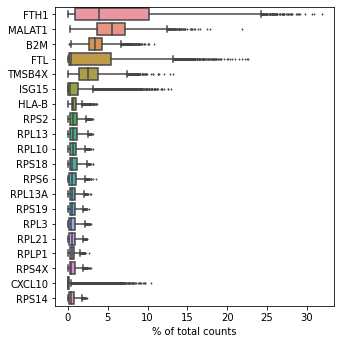

In [7]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [8]:
# check we don't have any weird cell types
adata.obs["scpred_CellType"].value_counts()


CD14_Mono      4361
CD4_Naive_T    2504
CD4_Mem_T      1762
B              1363
CD16_Mono      1044
CD8_T           813
T_Act           633
NK              619
DC              604
Mk              236
Name: scpred_CellType, dtype: int64

In [9]:
# write out data for BP and cibersort
dense_matrix = adata.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = adata.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=adata.obs["scpred_CellType"].to_list())


pickle.dump( dense_df, open( sc_profile_path, "wb" ) )


In [10]:
dense_matrix.shape

(13939, 13452)

# Plot Data

         Falling back to preprocessing with `sc.pp.pca` and default params.


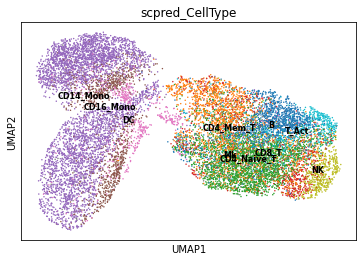

In [11]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

### First do some QC stats

In [12]:
adata.obs["sample_id"].value_counts()


1015    3177
1256    2396
1488    2280
1244    2031
1016    1484
101     1224
1039     679
107      668
Name: sample_id, dtype: int64

In [13]:
adata.obs

,orig.ident,nCount_RNA,nFeature_RNA,stim,seurat_annotations,seurat_names,seurat_names_merged,BARCODE,sample_id,n_genes,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,CellType,scpred_CellType
AAACATACATTTCC.1,IMMUNE_CTRL,3017.0,877,CTRL,0,CD14_Mono,CD14_Mono,AAACATACATTTCC.1CTRL,1016,877,877,3017.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCAGAAA.1,IMMUNE_CTRL,2481.0,713,CTRL,0,CD14_Mono,CD14_Mono,AAACATACCAGAAA.1CTRL,1256,713,713,2481.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCTCGCT.1,IMMUNE_CTRL,3420.0,850,CTRL,0,CD14_Mono,CD14_Mono,AAACATACCTCGCT.1CTRL,1256,850,850,3420.0,0.0,0.0,CD14_Mono,CD14_Mono
AAACATACCTGGTA.1,IMMUNE_CTRL,3156.0,1109,CTRL,11,pDC,DC,AAACATACCTGGTA.1CTRL,1039,1109,1109,3156.0,0.0,0.0,DC,DC
AAACATACGATGAA.1,IMMUNE_CTRL,1868.0,634,CTRL,2,CD4_Mem_T,CD4_Mem_T,AAACATACGATGAA.1CTRL,1488,634,634,1868.0,0.0,0.0,CD4_Mem_T,CD4_Mem_T
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGCATGAACGAA.1,IMMUNE_STIM,5577.0,1237,STIM,8,DC,DC,TTTGCATGAACGAA.1STIM,1244,1237,1237,5577.0,0.0,0.0,DC,DC
TTTGCATGACGTAC.1,IMMUNE_STIM,1364.0,536,STIM,2,CD4_Mem_T,CD4_Mem_T,TTTGCATGACGTAC.1STIM,1488,536,536,1364.0,0.0,0.0,CD4_Mem_T,CD4_Mem_T
TTTGCATGCCTGTC.1,IMMUNE_STIM,2114.0,817,STIM,4,B,B,TTTGCATGCCTGTC.1STIM,1256,817,817,2114.0,0.0,0.0,B,B
TTTGCATGCTAAGC.1,IMMUNE_STIM,1522.0,523,STIM,1,CD4_Naive_T,CD4_Naive_T,TTTGCATGCTAAGC.1STIM,107,523,523,1522.0,0.0,0.0,CD4_Naive_T,CD4_Naive_T


In [14]:
adata.obs["scpred_CellType"].unique()

['CD14_Mono', 'DC', 'CD4_Mem_T', 'T_Act', 'CD4_Naive_T', 'CD8_T', 'Mk', 'B', 'CD16_Mono', 'NK']
Categories (10, object): ['B', 'CD4_Mem_T', 'CD4_Naive_T', 'CD8_T', ..., 'DC', 'Mk', 'NK', 'T_Act']

### now split test and train cells

In [15]:
# generate cell-type specific split
adata.obs["isTraining"] = "Train"
adata.obs["test_train_key"] = adata.obs["scpred_CellType"].astype(str) + adata.obs["stim"].astype(str) + adata.obs["sample_id"].astype(str)

# for each element in the key
# split by 50%
for curr_key in adata.obs["test_train_key"].unique():
  curr_idx = np.where(adata.obs["test_train_key"] == curr_key)[0]
  num_sample = np.floor(len(curr_idx)/2).astype(int)
  test_idx = np.random.choice(curr_idx, num_sample)
  adata.obs["isTraining"][test_idx] = "Test"

<ipython-input-15-1a121793578e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["isTraining"][test_idx] = "Test"


In [16]:
pd.set_option('display.max_rows', 160)

tab = adata.obs.groupby(['test_train_key', 'isTraining']).size()

tab.unstack()

isTraining,Test,Train
test_train_key,,
BCTRL101,20,23
BCTRL1015,71,117
BCTRL1016,20,33
BCTRL1039,7,12
BCTRL107,8,17
BCTRL1244,22,47
BCTRL1256,43,66
BCTRL1488,34,51
BSTIM101,32,50


In [17]:
tab = adata.obs.groupby(['isTraining', 'sample_id']).size()

tab.unstack()

sample_id,101,107,1015,1016,1039,1244,1256,1488
isTraining,,,,,,,,
Test,487,270,1259,578,266,792,943,877
Train,737,398,1918,906,413,1239,1453,1403


In [18]:
tab = adata.obs.groupby(['isTraining', 'stim']).size()

tab.unstack()

stim,CTRL,STIM
isTraining,,
Test,2552,2920
Train,3971,4496


### Generate proportions matrix + pseudobulk

In [19]:
stim_idx = np.where(np.logical_and(adata.obs.stim == "STIM", adata.obs.isTraining == "Train"))[0]
tab = adata.obs.iloc[stim_idx].groupby(['sample_id', 'scpred_CellType']).size()
a = tab.unstack()
a.div(a.sum(axis=1), axis=0)

scpred_CellType,B,CD4_Mem_T,CD4_Naive_T,CD8_T,CD14_Mono,CD16_Mono,DC,Mk,NK,T_Act
sample_id,,,,,,,,,,
101,0.114943,0.142529,0.052874,0.071264,0.312644,0.142529,0.064368,0.016092,0.039080,0.043678
107,0.116751,0.167513,0.065990,0.025381,0.411168,0.060914,0.045685,0.010152,0.050761,0.045685
1015,0.136364,0.120507,0.067653,0.077167,0.363636,0.099366,0.024313,0.010571,0.067653,0.032770
1016,0.076110,0.078224,0.095137,0.162791,0.344609,0.105708,0.031712,0.008457,0.035941,0.061311
1039,0.064000,0.180000,0.152000,0.052000,0.340000,0.064000,0.056000,0.020000,0.024000,0.048000
1244,0.073211,0.128120,0.379368,0.039933,0.236273,0.014975,0.043261,0.016639,0.038270,0.029950
1256,0.101093,0.101093,0.316940,0.042350,0.263661,0.045082,0.036885,0.013661,0.043716,0.035519
1488,0.118329,0.126450,0.337587,0.025522,0.171694,0.059165,0.044084,0.025522,0.027842,0.063805


In [20]:
a_corr = np.corrcoef(a)
a_corr = pd.DataFrame(a_corr, columns=a.index.to_list())
a_corr

,101,107,1015,1016,1039,1244,1256,1488
0,1.000000,0.942602,0.960065,0.874925,0.870334,0.338948,0.496485,0.271358
1,0.942602,1.000000,0.966483,0.844011,0.935307,0.468791,0.604183,0.373642
2,0.960065,0.966483,1.000000,0.911201,0.880734,0.427341,0.588640,0.336864
3,0.874925,0.844011,0.911201,1.000000,0.832738,0.444344,0.586388,0.321785
4,0.870334,0.935307,0.880734,0.832738,1.000000,0.694983,0.776881,0.597965
5,0.338948,0.468791,0.427341,0.444344,0.694983,1.000000,0.976308,0.965959
6,0.496485,0.604183,0.588640,0.586388,0.776881,0.976308,1.000000,0.939916
7,0.271358,0.373642,0.336864,0.321785,0.597965,0.965959,0.939916,1.000000


In [21]:
stim_idx = np.where(np.logical_and(adata.obs.stim == "STIM", adata.obs.isTraining == "Test"))[0]
tab = adata.obs.iloc[stim_idx].groupby(['sample_id', 'scpred_CellType']).size()
a = tab.unstack()
a.div(a.sum(axis=1), axis=0)

scpred_CellType,B,CD4_Mem_T,CD4_Naive_T,CD8_T,CD14_Mono,CD16_Mono,DC,Mk,NK,T_Act
sample_id,,,,,,,,,,
101,0.109215,0.129693,0.064846,0.071672,0.327645,0.143345,0.058020,0.013652,0.034130,0.047782
107,0.109489,0.131387,0.065693,0.021898,0.452555,0.058394,0.058394,0.014599,0.043796,0.043796
1015,0.147727,0.129870,0.056818,0.081169,0.353896,0.089286,0.027597,0.011364,0.071429,0.030844
1016,0.070470,0.067114,0.080537,0.174497,0.352349,0.117450,0.026846,0.010067,0.033557,0.067114
1039,0.084967,0.196078,0.137255,0.065359,0.313725,0.052288,0.045752,0.032680,0.019608,0.052288
1244,0.058974,0.128205,0.374359,0.033333,0.243590,0.015385,0.043590,0.017949,0.051282,0.033333
1256,0.089980,0.098160,0.316973,0.049080,0.267894,0.047035,0.038855,0.018405,0.036810,0.036810
1488,0.108456,0.125000,0.336397,0.022059,0.183824,0.060662,0.040441,0.025735,0.031250,0.066176


In [22]:
a_corr = np.corrcoef(a)
a_corr = pd.DataFrame(a_corr, columns=a.index.to_list())
a_corr

,101,107,1015,1016,1039,1244,1256,1488
0,1.000000,0.943680,0.955893,0.890035,0.869464,0.393754,0.548569,0.344282
1,0.943680,1.000000,0.957980,0.841225,0.906576,0.481173,0.610570,0.392826
2,0.955893,0.957980,1.000000,0.873424,0.869330,0.405834,0.555520,0.335362
3,0.890035,0.841225,0.873424,1.000000,0.769486,0.388496,0.546679,0.290591
4,0.869464,0.906576,0.869330,0.769486,1.000000,0.674316,0.749304,0.603995
5,0.393754,0.481173,0.405834,0.388496,0.674316,1.000000,0.975222,0.965054
6,0.548569,0.610570,0.555520,0.546679,0.749304,0.975222,1.000000,0.946356
7,0.344282,0.392826,0.335362,0.290591,0.603995,0.965054,0.946356,1.000000


In [23]:
stim_idx = np.where(np.logical_and(adata.obs.stim == "CTRL", adata.obs.isTraining == "Train"))[0]
tab = adata.obs.iloc[stim_idx].groupby(['sample_id', 'scpred_CellType']).size()
a = tab.unstack()
a.div(a.sum(axis=1), axis=0)

scpred_CellType,B,CD4_Mem_T,CD4_Naive_T,CD8_T,CD14_Mono,CD16_Mono,DC,Mk,NK,T_Act
sample_id,,,,,,,,,,
101,0.076159,0.142384,0.026490,0.069536,0.350993,0.152318,0.059603,0.023179,0.033113,0.066225
107,0.084577,0.149254,0.049751,0.009950,0.507463,0.064677,0.059701,0.014925,0.039801,0.019900
1015,0.120370,0.135802,0.055556,0.058642,0.389918,0.094650,0.030864,0.015432,0.062757,0.036008
1016,0.076212,0.076212,0.085450,0.110855,0.404157,0.115473,0.039261,0.011547,0.020785,0.060046
1039,0.073620,0.171779,0.128834,0.049080,0.355828,0.061350,0.042945,0.012270,0.049080,0.055215
1244,0.073668,0.137931,0.235110,0.056426,0.304075,0.042320,0.064263,0.021944,0.037618,0.026646
1256,0.091540,0.099861,0.294036,0.037448,0.263523,0.036061,0.038835,0.019417,0.059639,0.059639
1488,0.094270,0.175601,0.214418,0.031423,0.227357,0.081331,0.060998,0.022181,0.040665,0.051756


In [24]:
a_corr = np.corrcoef(a)
a_corr = pd.DataFrame(a_corr, columns=a.index.to_list())
a_corr

,101,107,1015,1016,1039,1244,1256,1488
0,1.000000,0.939753,0.950800,0.935856,0.884070,0.652409,0.440969,0.601107
1,0.939753,1.000000,0.979894,0.931882,0.954214,0.790855,0.610023,0.700790
2,0.950800,0.979894,1.000000,0.945185,0.942704,0.762254,0.591209,0.686630
3,0.935856,0.931882,0.945185,1.000000,0.903146,0.772445,0.618357,0.644446
4,0.884070,0.954214,0.942704,0.903146,1.000000,0.903959,0.762510,0.854695
5,0.652409,0.790855,0.762254,0.772445,0.903959,1.000000,0.944072,0.943611
6,0.440969,0.610023,0.591209,0.618357,0.762510,0.944072,1.000000,0.907290
7,0.601107,0.700790,0.686630,0.644446,0.854695,0.943611,0.907290,1.000000


In [25]:
stim_idx = np.where(np.logical_and(adata.obs.stim == "CTRL", adata.obs.isTraining == "Test"))[0]
tab = adata.obs.iloc[stim_idx].groupby(['sample_id', 'scpred_CellType']).size()
a = tab.unstack()
a.div(a.sum(axis=1), axis=0)

scpred_CellType,B,CD4_Mem_T,CD4_Naive_T,CD8_T,CD14_Mono,CD16_Mono,DC,Mk,NK,T_Act
sample_id,,,,,,,,,,
101,0.103093,0.139175,0.020619,0.056701,0.355670,0.159794,0.056701,0.010309,0.036082,0.061856
107,0.060150,0.142857,0.060150,0.015038,0.518797,0.082707,0.052632,0.015038,0.045113,0.007519
1015,0.110420,0.143079,0.054432,0.049767,0.405910,0.093313,0.029549,0.012442,0.060653,0.040435
1016,0.071429,0.067857,0.071429,0.132143,0.396429,0.114286,0.039286,0.014286,0.032143,0.060714
1039,0.061947,0.194690,0.123894,0.044248,0.353982,0.061947,0.061947,0.017699,0.044248,0.035398
1244,0.054726,0.126866,0.233831,0.049751,0.333333,0.034826,0.084577,0.022388,0.034826,0.024876
1256,0.094714,0.094714,0.281938,0.039648,0.292952,0.039648,0.033040,0.015419,0.050661,0.057269
1488,0.102102,0.195195,0.201201,0.033033,0.210210,0.078078,0.057057,0.027027,0.030030,0.066066


In [26]:
a_corr = np.corrcoef(a)
a_corr = pd.DataFrame(a_corr, columns=a.index.to_list())
a_corr

,101,107,1015,1016,1039,1244,1256,1488
0,1.000000,0.935156,0.958854,0.911680,0.862835,0.654583,0.521487,0.579941
1,0.935156,1.000000,0.982308,0.925091,0.949856,0.828496,0.691791,0.661826
2,0.958854,0.982308,1.000000,0.929736,0.935250,0.779787,0.671149,0.665656
3,0.911680,0.925091,0.929736,1.000000,0.842851,0.756481,0.652265,0.532171
4,0.862835,0.949856,0.935250,0.842851,1.000000,0.903671,0.779812,0.837026
5,0.654583,0.828496,0.779787,0.756481,0.903671,1.000000,0.944379,0.859348
6,0.521487,0.691791,0.671149,0.652265,0.779812,0.944379,1.000000,0.858070
7,0.579941,0.661826,0.665656,0.532171,0.837026,0.859348,0.858070,1.000000


In [41]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

# metadata
sample_order = ['1015', '1256', '1488', '1244', '1016', '101', '1039', '107']
sample_order = ['1015', '1256']
stim_order = ['STIM', 'CTRL']
train_order = ['Train', 'Test']

# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "stim", "isTraining"])

# no cell noise 
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = adata.obs.scpred_CellType.unique()

# simulate different number of cells
num_cells = 5000
idx = 0
for curr_samp in sample_order:

  # for all other samples
  for curr_stim in stim_order:

    sample_noise = None ## when suing training data -- this generates the sample_noise
    for curr_train in train_order:

      print(f"{res_name} {curr_samp} {curr_stim} {curr_train}")

      ########################################################
      ### GET CELLS TO SAMPLE FROM
      ########################################################
      # subset adata to get the correct cells to sample from
      subsamp_subset_idx = np.logical_and(adata.obs.sample_id == curr_samp, adata.obs.isTraining == curr_train)
      subsamp_subset_idx = np.logical_and(subsamp_subset_idx, adata.obs.stim == curr_stim)
      
      sampling_adata = adata[subsamp_subset_idx]


      ########################################################
      ### MAKE CORRELATED CELL TYPE PROPORTIONS MATRIX
      ########################################################
      # make the cell type proportion matrix

      curr_prop_df = sc_preprocess.get_random_prop_matrix(num_samp=1000, 
                                                          cell_order=cell_order)
      # get the single cell type proportions
      ct_prop_df = sc_preprocess.get_single_celltype_prop_matrix(num_samp=100,
                                                                  cell_order=cell_order)

      # put them together
      curr_prop_df = curr_prop_df.append(ct_prop_df)

      ########################################################
      ### MAKE PSEUDOBULKS
      ########################################################
      # now get the pseudobulks
      prop_df, pseudobulks_df, sample_noise = sc_preprocess.use_prop_make_sum(sampling_adata,  
                                                                  num_cells=num_cells, 
                                                                  props_vec=curr_prop_df, 
                                                                  cell_noise=cell_noise,
                                                                  sample_noise=None,
                                                                  useSampleNoise=False)


      # make the proportions instead of cell counts
      prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)
      pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_pseudo_splits.pkl")
      prop_file = os.path.join(aug_data_path, f"{res_name}_{curr_samp}_{curr_stim}_{curr_train}_prop_splits.pkl")

      pseudobulk_path = Path(pseudobulk_file)
      prop_path = Path(prop_file)

      pickle.dump( prop_df, open( prop_path, "wb" ) )
      pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )





all-kang 1015 STIM Train


<ipython-input-41-99a78daebacc>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  curr_prop_df = curr_prop_df.append(ct_prop_df)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
all-kang 1015 STIM Test


<ipython-input-41-99a78daebacc>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  curr_prop_df = curr_prop_df.append(ct_prop_df)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
all-kang 1015 CTRL Train


<ipython-input-41-99a78daebacc>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  curr_prop_df = curr_prop_df.append(ct_prop_df)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
all-kang 1015 CTRL Test


<ipython-input-41-99a78daebacc>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  curr_prop_df = curr_prop_df.append(ct_prop_df)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
all-kang 1256 STIM Train


<ipython-input-41-99a78daebacc>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  curr_prop_df = curr_prop_df.append(ct_prop_df)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
all-kang 1256 STIM Test


<ipython-input-41-99a78daebacc>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  curr_prop_df = curr_prop_df.append(ct_prop_df)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
all-kang 1256 CTRL Train


<ipython-input-41-99a78daebacc>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  curr_prop_df = curr_prop_df.append(ct_prop_df)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
all-kang 1256 CTRL Test


<ipython-input-41-99a78daebacc>:58: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  curr_prop_df = curr_prop_df.append(ct_prop_df)


0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
